In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [3]:
with open('../data/molecules_enh.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [4]:
structures = pd.read_feather('../data/structures_enh.feather')
molecules_df = pd.read_feather('../data/molecules.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



In [5]:
labelled_enh = labelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
labelled_enh.head(32)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,nC,nF,nH,nN,nO,nCNOF,nCN,nOF,nAtoms
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807602,1,0,4,0,0,1,1,0,5
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,1,0,4,0,0,1,1,0,5
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800,1,0,4,0,0,1,1,0,5
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300,1,0,4,0,0,1,1,0,5
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807404,1,0,4,0,0,1,1,0,5
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.254100,1,0,4,0,0,1,1,0,5
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.254800,1,0,4,0,0,1,1,0,5
7,7,dsgdb9nsd_000001,3,0,1JHC,84.809303,1,0,4,0,0,1,1,0,5
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.254300,1,0,4,0,0,1,1,0,5
9,9,dsgdb9nsd_000001,4,0,1JHC,84.809502,1,0,4,0,0,1,1,0,5


In [6]:
unlabelled_enh = unlabelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
unlabelled_enh.head(32)

,id,molecule_name,atom_index_0,atom_index_1,type,nC,nF,nH,nN,nO,nCNOF,nCN,nOF,nAtoms
0,4658147,dsgdb9nsd_000004,2,0,2JHC,2,0,2,0,0,2,2,0,4
1,4658148,dsgdb9nsd_000004,2,1,1JHC,2,0,2,0,0,2,2,0,4
2,4658149,dsgdb9nsd_000004,2,3,3JHH,2,0,2,0,0,2,2,0,4
3,4658150,dsgdb9nsd_000004,3,0,1JHC,2,0,2,0,0,2,2,0,4
4,4658151,dsgdb9nsd_000004,3,1,2JHC,2,0,2,0,0,2,2,0,4
5,4658152,dsgdb9nsd_000015,3,0,1JHC,2,0,6,0,1,3,2,1,9
6,4658153,dsgdb9nsd_000015,3,2,3JHC,2,0,6,0,1,3,2,1,9
7,4658154,dsgdb9nsd_000015,3,4,2JHH,2,0,6,0,1,3,2,1,9
8,4658155,dsgdb9nsd_000015,3,5,2JHH,2,0,6,0,1,3,2,1,9
9,4658156,dsgdb9nsd_000015,4,0,1JHC,2,0,6,0,1,3,2,1,9


In [7]:
len(labelled), len(labelled_enh)

(4658147, 4658147)

In [8]:
from models import NNModel, partition_data

#data_df = labelled[labelled.type == '1JHC'].head(10)
data_df = labelled_enh.head(1000)
train_df, test_df = partition_data(data_df, train_frac=1)
train_df = train_df.copy()
        
model = NNModel(model_args = dict(molecules=molecules,
                                  structures=structures))
#model.corr(train_df, train_df)
model.setup_data(train_df, train_df)

In [9]:
model.structures.columns

Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z', 'x_mean',
       'y_mean', 'z_mean', 'dist_to_mean'],
      dtype='object')

In [10]:
model.input_df.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'nC', 'nF', 'nH', 'nN', 'nO', 'nCNOF',
       'nCN', 'nOF', 'nAtoms', 'coupling_distance', 'atom_0', 'atom_1',
       'coupling_3JHC', 'coupling_1JHC', 'coupling_2JHN', 'coupling_2JHH',
       'coupling_3JHH', 'coupling_3JHN', 'coupling_1JHN', 'coupling_2JHC',
       'atom0_H', 'atom0_O', 'atom0_N', 'atom0_C', 'atom0_F', 'atom0_weight',
       'ai', 'atom0_dist_to_mean', 'atom0_fi', 'atom0_simple_fi', 'atomN_H',
       'atomN_O', 'atomN_N', 'atomN_C', 'atomN_F', 'atomN_weight',
       'atomN_dist_to_mean', 'atomN_fi', 'atomN_simple_fi', 'atom1_H',
       'atom1_O', 'atom1_N', 'atom1_C', 'atom1_F', 'atom1_weight',
       'atom1_dist_to_mean', 'atom1_fi', 'atom1_simple_fi', 'atom2_H',
       'atom2_O', 'atom2_N', 'atom2_C', 'atom2_F', 'atom2_weight',
       'atom2_dist_to_mean', 'atom2_fi', 'atom2_simple_fi', 'atom3_H',
       'atom3_O', 'atom3_N', 'atom3_C', 'atom3_F', 'atom3_weight'

In [11]:
model.input_df.dtypes

id                             int32
molecule_name                 object
atom_index_0                   int16
atom_index_1                   int16
type                        category
scalar_coupling_constant     float32
nC                              int8
nF                              int8
nH                              int8
nN                              int8
nO                              int8
nCNOF                           int8
nCN                             int8
nOF                             int8
nAtoms                          int8
coupling_distance            float32
atom_0                      category
atom_1                      category
coupling_3JHC                   int8
coupling_1JHC                   int8
coupling_2JHN                   int8
coupling_2JHH                   int8
coupling_3JHH                   int8
coupling_3JHN                   int8
coupling_1JHN                   int8
coupling_2JHC                   int8
atom0_H                         int8
a

In [12]:
labelled_enh.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,nC,nF,nH,nN,nO,nCNOF,nCN,nOF,nAtoms
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807602,1,0,4,0,0,1,1,0,5
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000,1,0,4,0,0,1,1,0,5
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254800,1,0,4,0,0,1,1,0,5
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300,1,0,4,0,0,1,1,0,5
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807404,1,0,4,0,0,1,1,0,5


In [13]:
import itertools

Training 5835 samples for 1JHC


W0809 02:13:18.200595 140240296773440 deprecation.py:506] From /home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0809 02:13:19.347951 140240296773440 deprecation.py:506] From /home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Evaluating 2501 samples
1JHC score: 0.5273478076374501 (trained on 5835 elements)
Training 468 samples for 1JHN
Evaluating 202 samples
1JHN score: 0.7502152797769248 (trained on 468 elements)
Training 8262 samples for 2JHC
Evaluating 3541 samples
2JHC score: -0.08739291361588708 (trained on 8262 elements)
Training 3786 samples for 2JHH
Evaluating 1624 samples
2JHH score: -0.05689449947342911 (trained on 3786 elements)
Training 912 samples for 2JHN
Evaluating 392 samples
2JHN score: -0.021063162149213315 (trained on 912 elements)
Training 10052 samples for 3JHC
Evaluating 4309 samples
3JHC score: 0.21884934497386432 (trained on 10052 elements)
Training 4414 samples for 3JHH
Evaluating 1893 samples
3JHH score: 0.46598573911745467 (trained on 4414 elements)
Training 1266 samples for 3JHN
Evaluating 543 samples
3JHN score: -0.4111690795660775 (trained on 1266 elements)


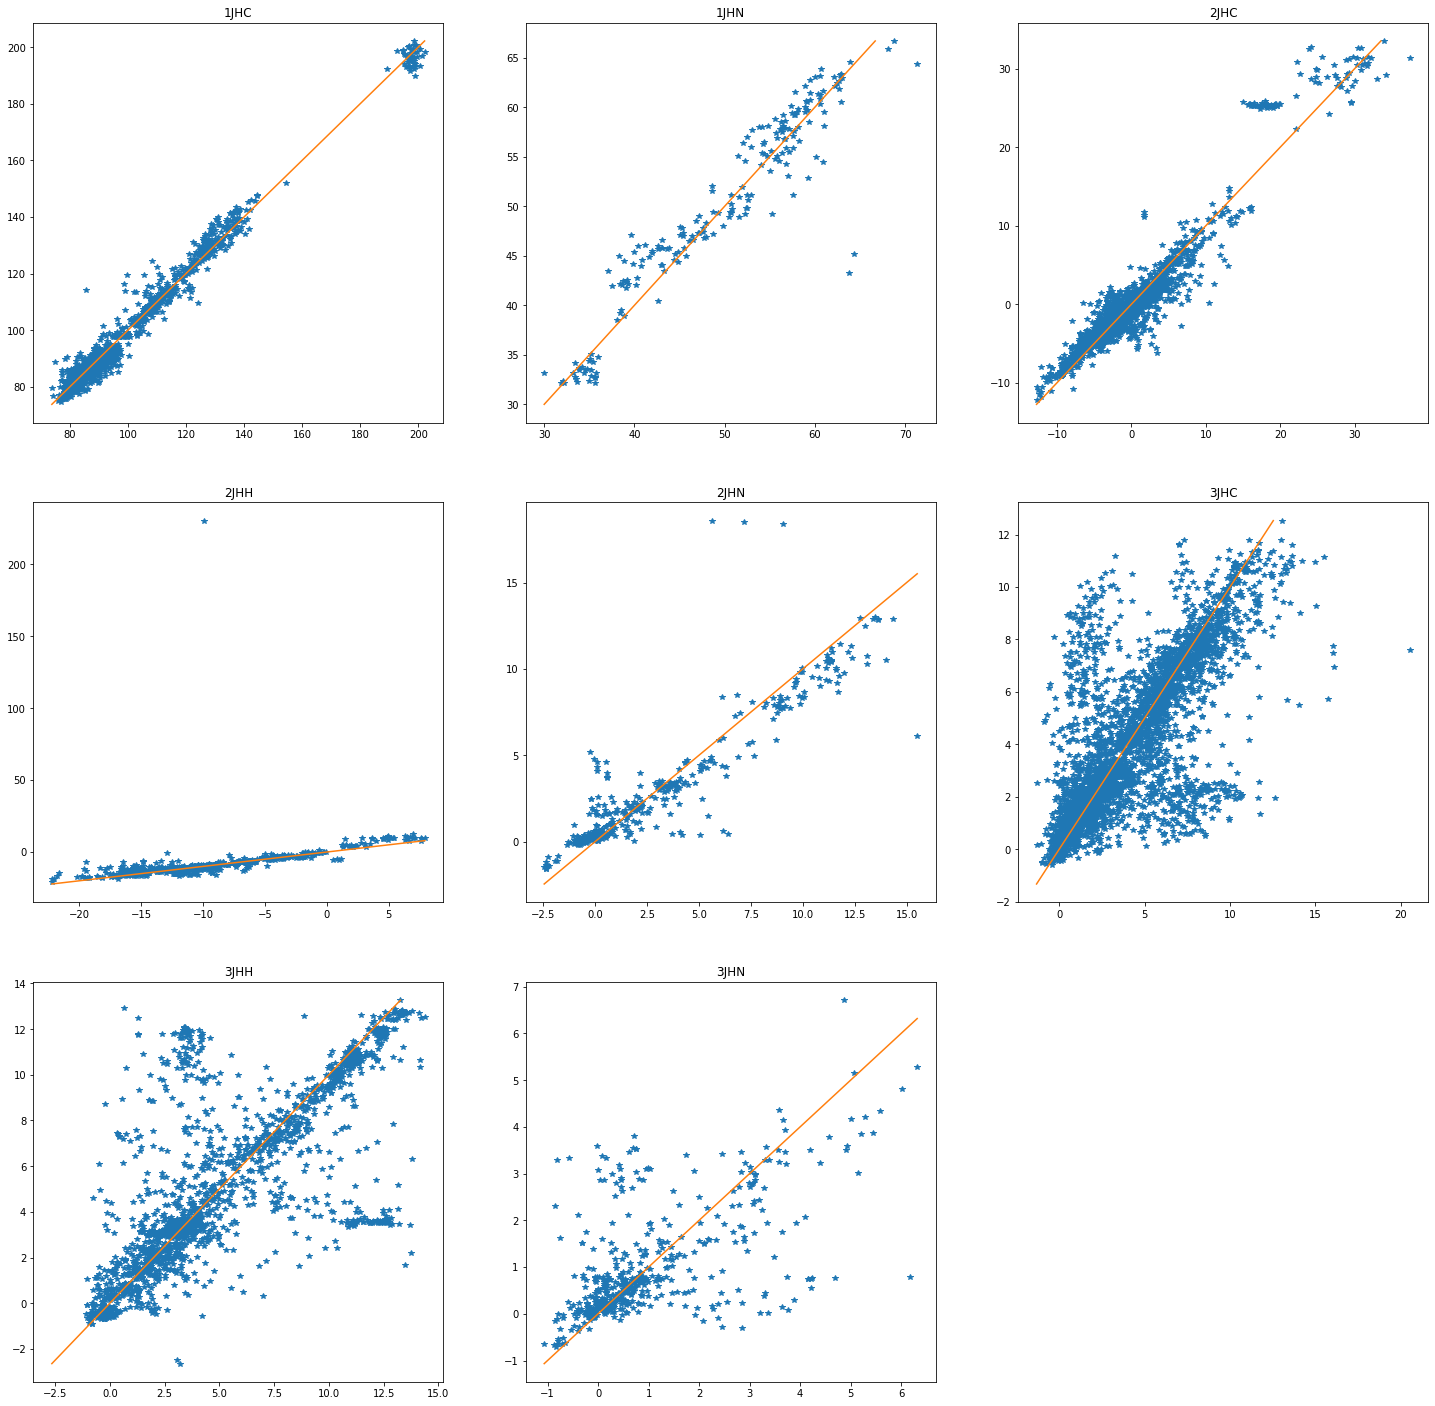

In [14]:
### from models import NNModel
from models import partition_data, NNModel

import tensorflow as tf
from tensorflow.keras import backend as tfbe

# atom_count_ranges = [(1, 10), (11, 15), (16, 20), (21, 25), (26, 30)]
# C_count_ranges = [(1, 5), (6, 6), (7, 7), (8, 9)]
coupling_types = sorted(labelled_enh.type.unique())
def test(data):
    global model
    
    plt.figure(figsize=(25, 25))
    
    for i, t in enumerate(coupling_types, 1):    
        data_df = data[data.type == t]

        train_df, test_df = partition_data(data_df)

        if len(train_df) < 10 or len(test_df) < 10:
            continue

        print(f'Training {len(train_df)} samples for {t}')

        model = NNModel(dict(molecules=molecules, 
                             structures=structures),
                        None)
        model.fit(train_df, train_df)

        print(f'Evaluating {len(test_df)} samples')
        output, score = model.evaluate(test_df, test_df)
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')


        #print(output.shape, test_df.values.shape)
        #pprint(list(zip(output[0:20, 0], test_df.scalar_coupling_constant[0:20])))

        plt.subplot(3, 3, i)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())

        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
                        
    plt.show()
        
test(labelled_enh.head(50000))


In [15]:
df = model.input_df

In [16]:
df.atom0_simple_fi

35648    10.977288
18125    10.633348
18066     9.692712
30773    11.314856
35680    10.465123
25934    13.655631
34897    11.887795
7027      9.833673
6854     11.856339
9541     10.945583
43705    11.218859
21778    11.959834
40832    10.613571
8674     10.561220
18738    11.822236
23617    10.802329
15664    10.474050
23623    11.346910
15725    11.348259
9444     10.287093
21895    10.298011
16927     9.573398
15252     9.300683
15971    10.649036
20018    10.526699
42425     9.734646
41396    11.360100
29962    11.480006
20171    10.925943
3261      9.444242
           ...    
25457    11.545439
49105    11.740401
5981     10.888718
30294    11.197933
20094    10.296371
21890    10.215747
15421     9.997465
23877    10.742707
21783    14.217334
30158    10.473260
3428     10.078012
12219     9.522705
17070    11.408690
16943     9.850569
21663     9.888646
4951     11.020964
3332      9.252275
15285    10.234225
16916     9.573042
45450    10.739727
16298    10.879006
3716     11.

In [ ]:
def train(data):
    models = {}
    for t in sorted(data.type.unique()):
        train_df = data[data.type == t]
        print(f'Training {len(train_df)} samples for {t}')
        model = NNModel(dict(molecules=molecules, 
                             structures=structures),
                        None)
        models[t] = model
        model.fit(train_df, train_df)
    
    return models

models = train(labelled_enh)

Training 709416 samples for 1JHC


In [ ]:
def predict(data, models):
    out_df = None
    
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        print(f'Predicting {len(predict_df)} samples for {t}')
        output = models[t].predict(predict_df)
        
        id = predict_df['id']
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output}, index=predict_df.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
    
#%prun -s cumulative f(unlabelled.head(10000))
prediction = predict(unlabelled_enh, models)

In [ ]:
prediction.head()

In [ ]:
prediction.to_csv('../data/pred.csv',index=False)